In [1]:
import os
import logging
from pathlib import Path

LOG_DIR = "../../logs"
os.makedirs(LOG_DIR, exist_ok=True)

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    handlers=[
        logging.FileHandler(f"{LOG_DIR}/yolo_binary.log"),
        logging.StreamHandler(),
    ],
)

logger = logging.getLogger(__name__)
logger.info("Starting YOLOv8 binary road anomaly experiment")

2026-02-01 20:38:50,207 | INFO | Starting YOLOv8 binary road anomaly experiment


In [2]:
# Original VOC dataset
DATA_ROOT = Path("../../India")
IMG_DIR = DATA_ROOT / "train" / "images"
XML_DIR = DATA_ROOT / "train" / "annotations" / "xmls"

assert IMG_DIR.exists()
assert XML_DIR.exists()

# Output YOLO dataset
YOLO_ROOT = Path("../../datasets/yolo_rdd_binary")

NUM_CLASSES = 1  # binary detection

In [3]:
# All anomaly classes from RDD
ANOMALY_CLASSES = {
    "D00", "D01", "D10",  # cracks
    "D11",               # pothole
    "D20", "D40",         # road damage / patch
    "D44",               # manhole
    "D50",               # other damage
}

CLASS_ID = 0  # road_anomaly

In [4]:
for split in ["train", "val"]:
    (YOLO_ROOT / "images" / split).mkdir(parents=True, exist_ok=True)
    (YOLO_ROOT / "labels" / split).mkdir(parents=True, exist_ok=True)

logger.info("YOLO binary directory structure created at %s", YOLO_ROOT)

2026-02-01 20:38:50,255 | INFO | YOLO binary directory structure created at ../../datasets/yolo_rdd_binary


In [5]:
import random

SEED = 42
VAL_RATIO = 0.2

image_files = sorted(IMG_DIR.glob("*.jpg"))
assert len(image_files) > 0

random.seed(SEED)
random.shuffle(image_files)

val_count = int(len(image_files) * VAL_RATIO)

val_images = set(image_files[:val_count])
train_images = set(image_files[val_count:])

logger.info("Total images: %d", len(image_files))
logger.info("Train images: %d | Val images: %d", len(train_images), len(val_images))

2026-02-01 20:38:50,309 | INFO | Total images: 7706
2026-02-01 20:38:50,310 | INFO | Train images: 6165 | Val images: 1541


In [6]:
import xml.etree.ElementTree as ET
import cv2

def convert_voc_to_yolo_binary(xml_path, img_path, out_txt):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    img = cv2.imread(str(img_path))
    if img is None:
        return False

    h, w = img.shape[:2]
    yolo_lines = []

    for obj in root.findall("object"):
        name = obj.find("name").text
        if name not in ANOMALY_CLASSES:
            continue

        bnd = obj.find("bndbox")

        xmin = float(bnd.find("xmin").text)
        ymin = float(bnd.find("ymin").text)
        xmax = float(bnd.find("xmax").text)
        ymax = float(bnd.find("ymax").text)

        # YOLO normalized format
        xc = ((xmin + xmax) / 2) / w
        yc = ((ymin + ymax) / 2) / h
        bw = (xmax - xmin) / w
        bh = (ymax - ymin) / h

        # Safety assertions
        if bw <= 0 or bh <= 0:
            continue

        yolo_lines.append(
            f"{CLASS_ID} {xc:.6f} {yc:.6f} {bw:.6f} {bh:.6f}"
        )

    if yolo_lines:
        out_txt.write_text("\n".join(yolo_lines))
        return True

    return False

In [7]:
import shutil

def process_split(image_set, split):
    img_out = YOLO_ROOT / "images" / split
    lbl_out = YOLO_ROOT / "labels" / split

    kept = 0

    for img_path in image_set:
        xml_path = XML_DIR / f"{img_path.stem}.xml"
        if not xml_path.exists():
            continue

        label_path = lbl_out / f"{img_path.stem}.txt"

        ok = convert_voc_to_yolo_binary(xml_path, img_path, label_path)
        if not ok:
            continue

        shutil.copy(img_path, img_out / img_path.name)
        kept += 1

    logger.info("[%s] Kept %d images with anomalies", split, kept)
    return kept


train_kept = process_split(train_images, "train")
val_kept = process_split(val_images, "val")

assert train_kept > 0
assert val_kept > 0

2026-02-01 20:39:02,799 | INFO | [train] Kept 2992 images with anomalies
2026-02-01 20:39:05,842 | INFO | [val] Kept 764 images with anomalies


In [8]:
train_imgs = len(list((YOLO_ROOT / "images/train").glob("*.jpg")))
train_lbls = len(list((YOLO_ROOT / "labels/train").glob("*.txt")))
val_imgs = len(list((YOLO_ROOT / "images/val").glob("*.jpg")))
val_lbls = len(list((YOLO_ROOT / "labels/val").glob("*.txt")))

logger.info("Train: %d images | %d labels", train_imgs, train_lbls)
logger.info("Val  : %d images | %d labels", val_imgs, val_lbls)

assert train_imgs == train_lbls
assert val_imgs == val_lbls

2026-02-01 20:39:05,876 | INFO | Train: 2992 images | 2992 labels
2026-02-01 20:39:05,876 | INFO | Val  : 764 images | 764 labels


In [9]:
yaml_text = f"""
path: {YOLO_ROOT.resolve()}
train: images/train
val: images/val

nc: 1
names:
  0: road_anomaly
""".strip()

yaml_path = YOLO_ROOT / "rdd_binary.yaml"
yaml_path.write_text(yaml_text)

print(yaml_path.read_text())

path: /home/saber/GitHub/road_anomaly_detection/datasets/yolo_rdd_binary
train: images/train
val: images/val

nc: 1
names:
  0: road_anomaly


In [10]:
from ultralytics import YOLO

MODELS = [
    #"yolov8n.pt",
    #"yolov8s.pt",
    "yolov8m.pt",
]

for m in MODELS:
    model = YOLO(m)
    model.train(
        data=str(yaml_path),
        epochs=140,
        imgsz=416,
        batch=4,
        device=0,          # GPU
        project="../../runs/standby_models",
        name=m.replace(".pt", "")
    )


Ultralytics 8.4.9 🚀 Python-3.12.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 7799MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../../datasets/yolo_rdd_binary/rdd_binary.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=140, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=yolov8m3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, over

# Inferencing

In [5]:
from ultralytics import YOLO

model = YOLO("../../runs/standby_models/yolov8m3/weights/best.pt")

results = model(
    source="../../India/test/images/",
    conf=0.25,
    save=True
)



WARNING ⚠️ 
Inference results will accumulate in RAM unless `stream=True` is passed, which can cause out-of-memory errors for large
sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/1959 /home/saber/GitHub/road_anomaly_detection/notebooks/India_data_only/../../India/test/images/India_000004.jpg: 416x416 1 road_anomaly, 7.3ms
image 2/1959 /home/saber/GitHub/road_anomaly_detection/notebooks/India_data_only/../../India/test/images/India_000006.jpg: 416x416 (no detections), 7.4ms
image 3/1959 /home/saber/GitHub/road_anomaly_detection/notebooks/India_data_only/../../India/test/images/India_000008.jpg: 416x416 1 road_anomaly, 6.6m

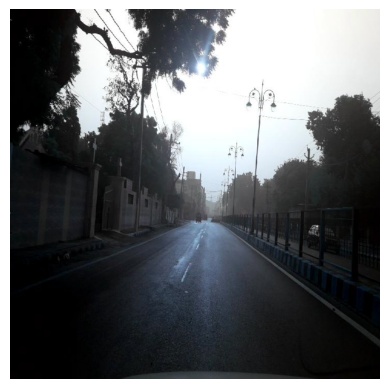

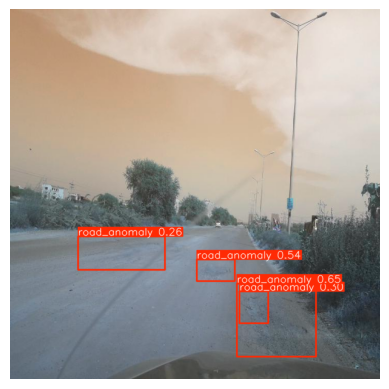

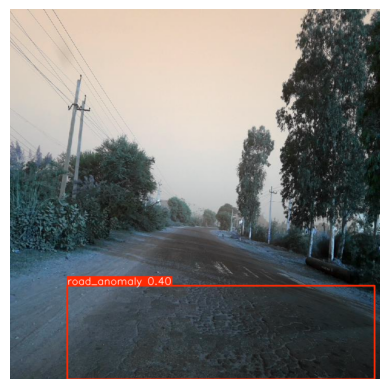

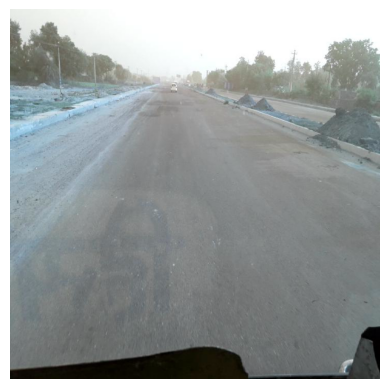

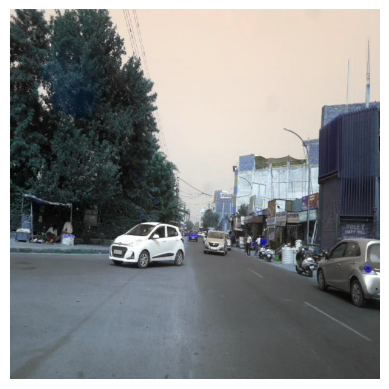

: 

In [ ]:
import matplotlib.pyplot as plt
import random

# results is a list — use random.sample to get a few random entries
sampled = random.sample(results, k=min(5, len(results)))

for r in sampled:   # show up to 5 test images after shuffling
    img = r.plot()     # numpy array with boxes drawn
    plt.imshow(img)
    plt.axis("off")
    plt.show()
